In [1]:
#IMPORT VARIOUS PYTHON PACKAGES
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import cmocean
import gsw
import seawater as sw
import datetime
import cartopy.crs as ccrs
import cartopy.feature
import scipy.stats
%matplotlib inline

In [2]:
#define a function that sets repeated values in an array to NaNs (needed to deal with profiles that do not cover the full range of the density grid you interpolate onto) 
def delete_rep(data):
        vals, inverse, count = np.unique(data, return_inverse=True,
                              return_counts=True)

        idx_vals_repeated = np.where(count > 1)[0]
        vals_repeated = vals[idx_vals_repeated]

        rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
        _, inverse_rows = np.unique(rows, return_index=True)
        res = np.split(cols, inverse_rows[1:]) #res gives the indices of the repeated values
    
        for n in range(len(res)): 
            data[res[n-1]]=np.nan #set the repeated values to nans
        return data

In [3]:
#read in QC flags and interpolate fields onto standard density grid, save temperature, pressure and oxygen on 36.8 isopycnal
def interpolate_sigma2(dataset):
        n_profs = dataset.N_PROF.size
        sal = dataset.Salinity[:, ::-1] 
        temp = dataset.Temperature[:, ::-1] 
        pres = dataset.Pressure[:, ::-1] 
        oxy = dataset.Oxygen[:, ::-1] 
        
        #set values to nan if bad QC flags
        sal.values[dataset.Salinity_QFA[:, ::-1].values==4]=np.nan
        sal.values[dataset.Salinity_QFA[:, ::-1].values==8]=np.nan
        temp.values[dataset.Temperature_QFA[:, ::-1].values==4]=np.nan
        temp.values[dataset.Temperature_QFA[:, ::-1].values==8]=np.nan
        oxy.values[dataset.Oxygen_QFA[:, ::-1].values==4]=np.nan
        oxy.values[dataset.Oxygen_QFA[:, ::-1].values==8]=np.nan
        
        #define standard sigma2 grid to interpolate data onto
        zi = np.arange(35, 37, 0.01)
        temp368=[]
        pres368=[]
        oxy368=[]
        
        for i in range(n_profs):
            SA=gsw.SA_from_SP(sal[i,:].values,pres[i,:].values,dataset.Lon[i].values,dataset.Lat[i].values)
            CT=gsw.CT_from_t(SA,temp[i,:].values,pres[i,:].values)
            SIG2=gsw.sigma2(SA,CT)
            
            #interpolate temperature and oxygen onto standard sigma2 gird
            temp_int = np.interp(zi, SIG2, temp[i,:].values)
            pres_int = np.interp(zi, SIG2, pres[i,:].values)
            oxy_int = np.interp(zi, SIG2, oxy[i,:].values)
            
            #delete repeated values in array (happens when you interpolate if the profile is not as dense as 37 or as light as 35)
            temp_int = delete_rep(temp_int)
            pres_int = delete_rep(pres_int)
            oxy_int = delete_rep(oxy_int)
            
            #save temperature 
            temp368.append(temp_int[180])
            pres368.append(pres_int[180])
            oxy368.append(oxy_int[180])
            
        return temp368,pres368,oxy368 

In [4]:
#array containing SOCCOM float ids
float_id = ['0506','0507','0508','0509','0510','0511','0564','0565','0566','0567','0568','0569','0570','0571',
            '0688','0689','0690','0691','0692','0693','0886','0888','0889','8204','8501','8514','9018','9031',
            '9091','9092','9094','9095','9096','9099','9101','9125','9254','9260','9265','9275','9313','9600',
            '9602','9630','9631','9632','9634','9637','9642','9645','9646','9650','9652','9655','9657','9659',
            '9660','9662','9666','9668','9744','9749','9750','9752','9757','9762','9766','11090','12361','12363',
            '12366','12369','12370','12371','12372','12379','12380','12381','12382','12386','12388','12390','12396',
            '12398','12537','12540','12541','12542','12543','12545','12549','12551','12552','12558','12559','12573',
            '12575','12688','12696','12700','12701','12702','12707','12708','12709','12711','12714','12723','12727',
            '12729','12730','12733','12734','12736','12739','12741','12742','12744','12745','12747','12748','12749',
            '12752','12754','12755','12757','12758','12768','12769','12778','12779','12781','12782','12784','12786',
            '12787','12878','12879','12880','12881','12882','12883','12884','12885','12886','12888','12889','12892',
            '17898','18013','18069','18081','18082','18097','18098','18110','18161','18169','18242','18299','18320',
            '18417','18545','18643','18721','18739','18771','18796','18821','18829','18852','18862','18864','18994']

In [5]:
len(float_id) #total of 174 floats

174

In [6]:
lat_all = []
lon_all = []
temp368 = []
pres368 = []
oxy368 = []

#read in the data from all floats using a loop 
for n in range(len(float_id)): 
    fd = xr.open_dataset('../Spring_2020/SOCCOM_LoResQC_LIAR_20Apr2020_netcdf/' + float_id[n] + 'SOOCNQC.nc')
    lat_all.append(fd.Lat.values)
    lon_all.append(fd.Lon.values)
    
    #Interpolate temperature onto uniform depth grid
    int_fd=interpolate_sigma2(fd)
    
    #Average data over the top 20 m of the watercolumn
    temp368.append(int_fd[0])
    pres368.append(int_fd[1])
    oxy368.append(int_fd[2])

In [7]:
temp368=np.asarray(temp368)
pres368=np.asarray(pres368)
oxy368=np.asarray(oxy368)

In [8]:
lat_fl=np.concatenate(lat_all).ravel()
lon_fl=np.concatenate(lon_all).ravel()
temp_fl=np.concatenate(temp368).ravel()
pres_fl=np.concatenate(pres368).ravel()
oxy_fl=np.concatenate(oxy368).ravel()

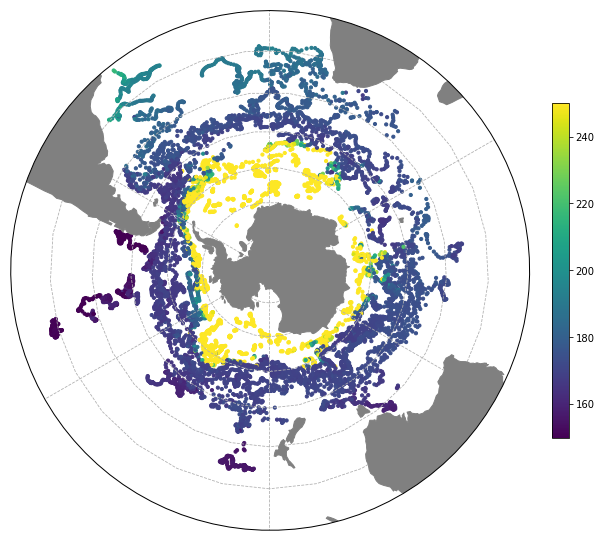

In [9]:
#PLOT OXYGEN ON 36.8 ISOPYCNAL
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -21], crs=ccrs.PlateCarree())
g = ax.gridlines(linestyle='--')

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=2)

sc=ax.scatter(lon_fl,lat_fl,c=oxy_fl,vmin=150,vmax=250,s=10,zorder=1,transform=ccrs.PlateCarree())

plt.colorbar(sc,fraction=0.03, pad=0.04)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
import matplotlib.path as mpath
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.show()

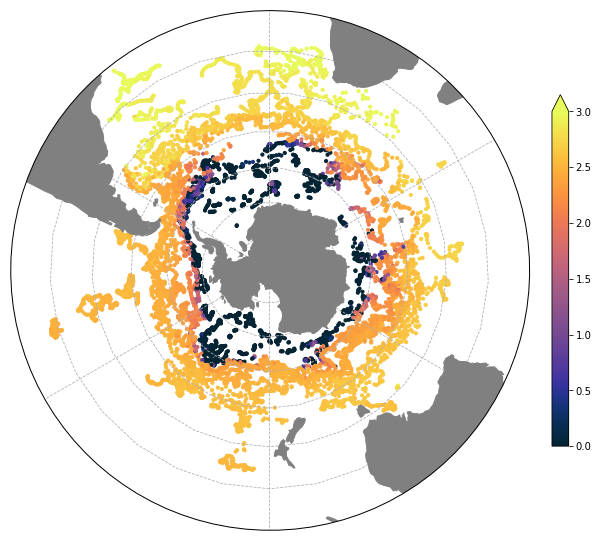

In [10]:
#PLOT TEMPERATURE ON 36.8 ISOPYCNAL
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -21], crs=ccrs.PlateCarree())
g = ax.gridlines(linestyle='--')

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=2)

sc=ax.scatter(lon_fl,lat_fl,c=temp_fl,vmin=0,vmax=3,s=10,cmap=cmocean.cm.thermal,zorder=1,transform=ccrs.PlateCarree())

plt.colorbar(sc,fraction=0.03, pad=0.04,extend='max')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
import matplotlib.path as mpath
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.show()

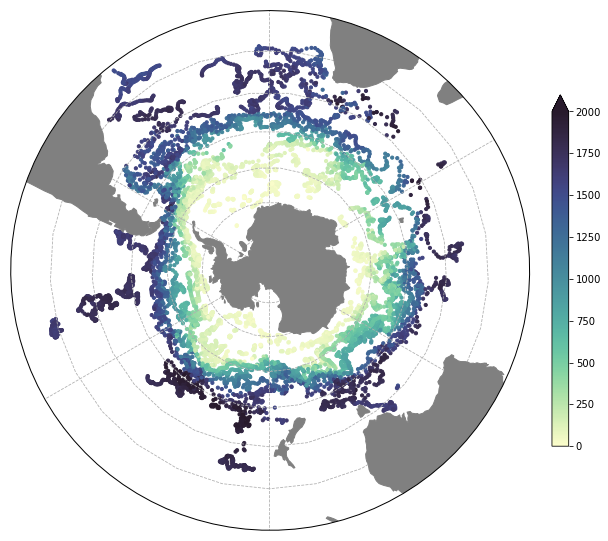

In [11]:
#PLOT TEMPERATURE ON 36.8 ISOPYCNAL
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -21], crs=ccrs.PlateCarree())
g = ax.gridlines(linestyle='--')

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=2)

sc=ax.scatter(lon_fl,lat_fl,c=pres_fl,vmin=0,vmax=2000,s=10,cmap=cmocean.cm.deep,zorder=1,transform=ccrs.PlateCarree())

plt.colorbar(sc,fraction=0.03, pad=0.04,extend='max')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
import matplotlib.path as mpath
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.show()

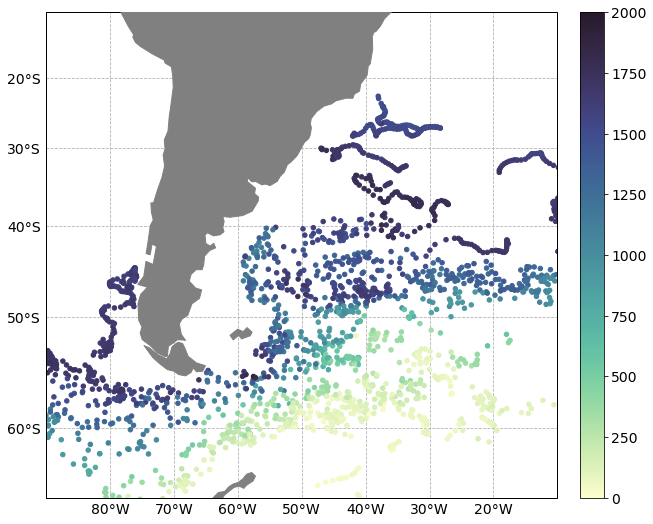

In [12]:
#PLOT A MAP OF PROFILE LOCATION (colored by pressure on the 36.8 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-90, -10, -10, -65], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

cs=ax.scatter(lon_fl,lat_fl,c=pres_fl,vmin=0,vmax=2000,cmap=cmocean.cm.deep,s=20,zorder=2,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0435, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

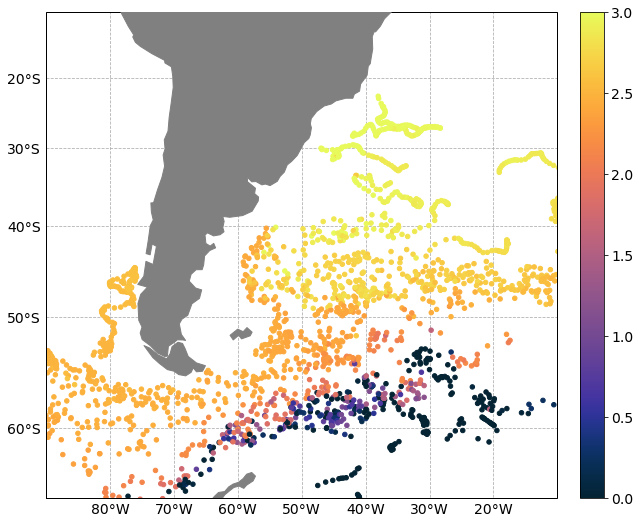

In [13]:
#PLOT A MAP OF PROFILE LOCATION (colored by pressure on the 36.8 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-90, -10, -10, -65], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

cs=ax.scatter(lon_fl,lat_fl,c=temp_fl,vmin=0,vmax=3,cmap=cmocean.cm.thermal,s=20,zorder=2,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0435, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

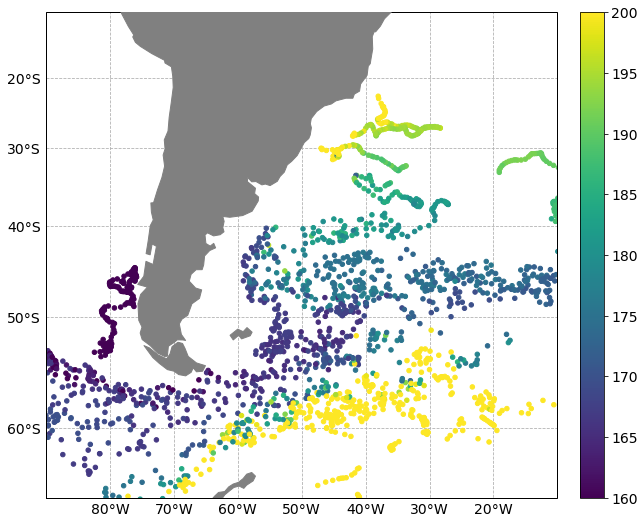

In [14]:
#PLOT A MAP OF PROFILE LOCATION (colored by pressure on the 36.8 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-90, -10, -10, -65], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

cs=ax.scatter(lon_fl,lat_fl,c=oxy_fl,vmin=160,vmax=200,s=20,zorder=2,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0435, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels

ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}